In [3]:
import numpy as np 
import pandas as pd 
import random as rn
import re
import nltk
import os

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from nltk.corpus import stopwords
from wordcloud import WordCloud

import umap # dimensionality reduction
import hdbscan # clustering
from functools import partial

# To perform the Bayesian Optimization for searching the optimum hyperparameters, 
# we use hyperopt package:
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

import collections
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

import utils

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

In [9]:
(rn.random()>0.04) and (lambda i : i>0)

<function __main__.<lambda>(i)>

In [27]:
rn.seed(a=42)

p = 0.004  # to randomly select 0.4% of the rows dataset is large

df_reviews = pd.read_csv("../largedata/steam.csv", skiprows=lambda i: i>0 and rn.random() > p, header=None)

# size of dataframe
print(df_reviews.shape)
# display the head of data
display(df_reviews.head())

(25436, 4)


,0,1,2,3
0,10,Ruined my life.,1,0
1,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
2,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
3,10,Game will be played forever,1,0
4,10,i can't stop playing :D,1,0


In [16]:
rn.random()

0.36756528879936134

In [13]:
help(rn.random)

Help on built-in function random:

random() method of random.Random instance
    random() -> x in the interval [0, 1).



In [29]:
df_reviews.columns = ["app_id","review_text","review_score","review_votes"]

In [30]:
df_reviews.head()

,app_id,review_text,review_score,review_votes
0,10,Ruined my life.,1,0
1,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
2,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
3,10,Game will be played forever,1,0
4,10,i can't stop playing :D,1,0


<Axes: xlabel='review_score', ylabel='count'>

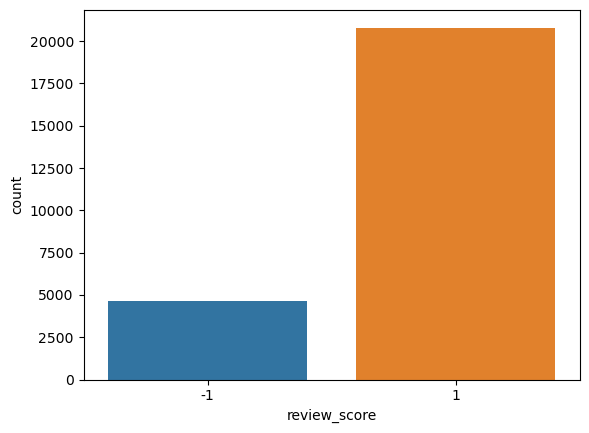

In [31]:
sns.countplot(x = "review_score", data = df_reviews)

In [32]:
df_reviews["review_score"].value_counts()

review_score
 1    20799
-1     4637
Name: count, dtype: int64

In [34]:
df_reviews.dtypes

app_id           int64
review_text     object
review_score     int64
review_votes     int64
dtype: object

In [35]:
# Flushing df data from RAM
#del df

In [36]:
df_reviews['review_text'] = df_reviews['review_text'].astype(str)
df_reviews['review_votes'] = df_reviews['review_votes'].astype(str)

In [37]:
df_reviews.dtypes

app_id           int64
review_text     object
review_score     int64
review_votes    object
dtype: object

In [38]:
df_reviews.head()

,app_id,review_text,review_score,review_votes
0,10,Ruined my life.,1,0
1,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
2,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
3,10,Game will be played forever,1,0
4,10,i can't stop playing :D,1,0


In [48]:
# Return a copy of the string with leading and trailing whitespace removed.
df_reviews["review_text"] = df_reviews["review_text"].apply(lambda s : s.strip())

df_reviews_2 = df_reviews[df_reviews['review_score'].notnull()]

df_reviews_2['review_score'] = np.where(df_reviews_2['review_score'] == -1, 0, df_reviews_2['review_score'])

df_reviews_2.head()

,app_id,review_text,review_score,review_votes
0,10,Ruined my life.,1,0
1,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
2,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
3,10,Game will be played forever,1,0
4,10,i can't stop playing :D,1,0


In [47]:
df_reviews[df_reviews['review_score'].isnull()]

,app_id,review_text,review_score,review_votes


# WordCloud

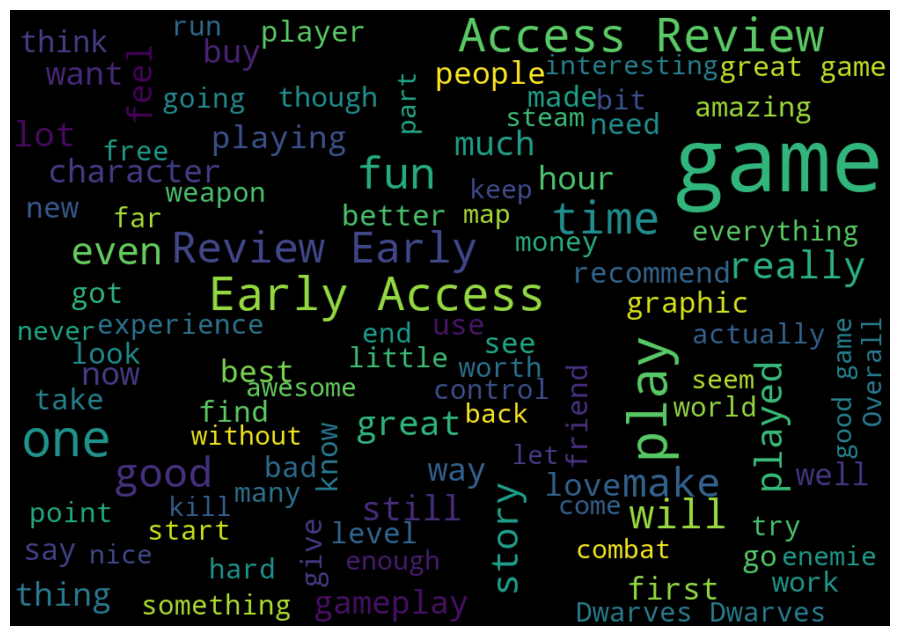

In [49]:
# concatinating the text for wordcloud

txt = ' '.join(rev for rev in df_reviews_2.review_text )

plt.figure(figsize=(15, 8))

wordcloud = WordCloud(
    background_color='black',
    max_font_size=100,
    max_words=100, 
    width=1000, 
    height=700
).generate(txt)

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')

plt.show()

In [51]:
# THere are many text that has same text that is Early Access Review more of a hard coded text
df_reviews_2[df_reviews_2.review_text == 'Early Access Review']

,app_id,review_text,review_score,review_votes
820,108600,Early Access Review,0,1
821,108600,Early Access Review,1,0
822,108600,Early Access Review,1,0
823,108600,Early Access Review,1,0
824,108600,Early Access Review,1,0
...,...,...,...,...
23565,538100,Early Access Review,1,0
23573,544840,Early Access Review,1,1
23574,545050,Early Access Review,1,1
23575,545050,Early Access Review,1,0


In [52]:
# reviews that are not nan
df_reviews_2[~df_reviews_2.review_text.isin(['nan'])]

,app_id,review_text,review_score,review_votes
0,10,Ruined my life.,1,0
1,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
2,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
3,10,Game will be played forever,1,0
4,10,i can't stop playing :D,1,0
...,...,...,...,...
25431,99810,Hilarious game with great gameplay,1,0
25432,99810,I guess manually updating GFWL makes me a computer genuis or something.,1,0
25433,99910,nice game to play,1,0
25434,99910,This was my favorite game when the game was still building up 10ish years ago. The game now shows many signs of being dated and is no longer receiving regular content updates. The people running the game are recycling ideas month after month and are still running events that were popular when I first started. The game could use a major refresh and I hope to see this game become great once again.,0,0


In [53]:
df_reviews_2.review_text.isna().sum()

0

In [54]:
df_reviews_2 = df_reviews_2[df_reviews_2.review_text != 'Early Access Review']

df_reviews_2 = df_reviews_2[~df_reviews_2.review_text.isin(['nan'])]



df_reviews_2.drop_duplicates(['review_text', 'review_score' ], inplace = True )

print(df_reviews_2.shape)

(21179, 4)


In [55]:
df_reviews_2.head()

,app_id,review_text,review_score,review_votes
0,10,Ruined my life.,1,0
1,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
2,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
3,10,Game will be played forever,1,0
4,10,i can't stop playing :D,1,0


In [56]:
df_reviews_2.head()


,app_id,review_text,review_score,review_votes
0,10,Ruined my life.,1,0
1,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
2,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
3,10,Game will be played forever,1,0
4,10,i can't stop playing :D,1,0


In [57]:
def replace_hearts_with_PAD(text):
    return re.sub(r"[♥]+", ' **** ' ,text)

# df_reviews_2['review_text_clean'] = df_reviews_2.review_text.apply(replace_hearts_with_PAD)

# df_reviews_2.head()

# Function to remove emoji

In [58]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

# Clean some basic characters

In [59]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

# Remove numeric

In [60]:
def remove_num(texts):
    output = re.sub(r'\d+', '', texts )
    return output

# Function to unify whitespaces

In [61]:
# multiple white spaces
def unify_whitespaces(text):
    cleaned_string = re.sub(' +', ' ', text )
    return cleaned_string

In [62]:
re.sub(' +'," ","hi     world")

'hi world'

# Function to remove punctuation

In [63]:

def remove_punctuation(text):
    result = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',',') )
    return result

# Remove stopwords

In [64]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

stop = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemma = WordNetLemmatizer()

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop ]
    return ' '.join(text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Function to use stemming to normalize words

In [65]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

def Stemming(text):
    stem = []
    stopword = stopwords.words('english')
    snowball_stemmer = SnowballStemmer('english')
    word_tokens = nltk.word_tokenize(text)
    stemmed_word = [ snowball_stemmer.stem(word) for word in word_tokens ]
    stem = ' '.join(stemmed_word)
    return stem

# Applying all the cleaning util methods

In [66]:
def cleaning(df, review):
    df_processed = df.copy()
    df_processed[review] = df_processed['review_text']
    df_processed[review] = df_processed[review].apply(clean)
    df_processed[review] = df_processed[review].apply(deEmojify)
    df_processed[review] = df_processed[review].apply(replace_hearts_with_PAD)
    df_processed[review] = df_processed[review].apply(remove_num)
    df_processed[review] = df_processed[review].apply(remove_punctuation)
    df_processed[review] = df_processed[review].apply(remove_stopwords)
    df_processed[review] = df_processed[review].apply(unify_whitespaces)
    df_processed[review] = df_processed[review].apply(Stemming)
    return df_processed

df_processed = cleaning(df_reviews_2, 'review_text_clean' )

In [67]:
df_processed.head()

,app_id,review_text,review_score,review_votes,review_text_clean
0,10,Ruined my life.,1,0,ruin life
1,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1,think got skill came csgo think got skill caus came cod think got skill caus bought fallout still got money left steam account well let tell stori go suck * * * * alot * * * *
2,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0,( i ve delet comment want give serious review game delet older one ya go ) older counter-strik peopl know peopl usual find enjoy play due either out-dat ' glitchi ' person tend enjoy game time time origin game made first sourc engin old school shooter general ai n't shabbi either due game small amount space fill comput rare ever lag make sure interrupt enjoy also competit present counter-strik...
3,10,Game will be played forever,1,0,game play forev
4,10,i can't stop playing :D,1,0,ca n't stop play


# Randomly selecting 2000 negative reviews

In [68]:
neg_reviews = df_processed[df_processed.review_score == 0]

neg_reviews = neg_reviews.sample(n = 2000, random_state=1234)

all_intents = neg_reviews.review_text_clean.tolist()

print(neg_reviews.shape)

(2000, 5)


In [69]:
neg_reviews.head()

,app_id,review_text,review_score,review_votes,review_text_clean
4383,218620,"I used to love playing this game for its fantastic co-op, pefect for getting couple of friends and having a good time. But with the microtransactions? Seriously Overkill? Way to kill your modding community. This isn't CS:GO.",0,0,use love play game fantast co-op pefect get coupl friend good time microtransact serious overkil way kill mod communiti csgo
23347,50300,"If you want to play the game on easy difficulty than do it, it's probably good. I tried playing it on hard difficulty and it just turns out to be impossible. Apart from the stupidly tedious controls and all but responsive animations( i.e. your character will get stuck between objects, will have an incredibly hard time deciding whether to go out of cover or reload, glitching out really bad, and...",0,0,want play game easi difficulti probabl good tri play hard difficulti turn imposs apart stupid tedious control respons anim ( ie charact get stuck object incred hard time decid whether go cover reload glitch realli bad lot troubl anyth run straight ) let finish game stun stupid suicid ai teammat anyth help time they ll go enemi fire die like * * * * es tri get better cover they ll keep shoot wa...
2313,204060,Bad game. Not worth any money.,0,0,bad game worth money
23459,51100,this is my first ever game on steam i have masterd quick scoping and what the ♥♥♥♥! they removed snipers how could they is this a glitch or a mistake if its gone this game is broken,0,0,first ever game steam masterd quick scope * * * * remov sniper could glitch mistak gone game broken
24870,7770,"This game is one of the worst X-COM Games ever made. Horrible Graphics. Annoying Voices. Boring. Over Powered weapons can be unlocked early in-game, making the game just a matter of paitence. Window 10 user? Won't allow you to see ANYTHING OTHER THAN THE TOP LEFT CORNER. Sure, the types of weapon isn't in any other X-COM game, but then, the game is just plain off a waste of 5 dollars.",0,1,game one worst x-com game ever made horribl graphic annoy voic bore power weapon unlock earli in-gam make game matter paitenc window user allow see anyth top left corner sure type weapon x-com game game plain wast dollar


In [71]:
len(all_intents)

2000

In [73]:
# We will split the reviews into sentences as few reviews are really very lengthy having multiple topics.
# so that we can have better topics for different sentences
# We will keep sentences only if it has more than 4 words

In [74]:
all_sents = []

for intent in all_intents:
    for sent in nltk.sent_tokenize(intent):
        if len(sent.split()) > 4:
            all_sents.append(sent)

print(len(all_sents))

all_intent = all_sents

1793


# Sentence Embedding

In [76]:
from sentence_transformers import SentenceTransformer
import tensorflow as tf

In [77]:
def embed(model, model_type, sentences):
    if model_type =="use":
        embeddings = model(sentences)
    elif model_type == "sentence transformer":
        embeddings = model.encode(sentences)
    
    return embeddings

model_st1 = SentenceTransformer("all-mpnet-base-v2", device = "cpu")
embeddings_st1 = embed(model_st1, "sentence transformer", all_intents)

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [79]:
embeddings_st1.shape
# 768 features - 768 dimensional vector

(2000, 768)

# Dimensionality Reduction

## Use Bayesian Optimization with Hyperopt

Following are four common methods of hyperparameter optimization for machine learning in order of increasing efficiency:

1. Manual

2. Grid search

3. Random search

4. Bayesian model-based optimization

The one-sentence summary of Bayesian hyperparameter optimization is: build a probability model of the objective function and use it to select the most promising hyperparameters to evaluate in the true objective function.

In [80]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,32)),
    "n_components": hp.choice('n_components', range(3,32)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,32)),
    "random_state": 42
}

label_lower = 10
label_upper = 100
max_evals = 25 # change it to 50 or 100 for extra steps as you wish.

In [81]:
# import importlib
# importlib.reload(utils)

In [82]:
%%time
from utils import *
best_params_use, best_clusters_use, trials_use = utils.bayesian_search(embeddings_st1, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

  0%|                                                                              | 0/25 [00:00<?, ?trial/s, best loss=?]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



  4%|██▌                                                              | 1/25 [00:08<03:13,  8.08s/trial, best loss: 1.424]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



  8%|█████                                                           | 2/25 [00:13<02:24,  6.28s/trial, best loss: 1.3535]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 12%|███████▋                                                        | 3/25 [00:19<02:19,  6.32s/trial, best loss: 1.3535]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 16%|██████████▏                                                     | 4/25 [00:25<02:11,  6.28s/trial, best loss: 1.3535]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 20%|████████████▊                                                   | 5/25 [00:33<02:18,  6.90s/trial, best loss: 1.3535]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 24%|███████████████▎                                                | 6/25 [00:42<02:24,  7.60s/trial, best loss: 1.3535]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 28%|█████████████████▉                                              | 7/25 [00:49<02:09,  7.20s/trial, best loss: 1.3535]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 32%|████████████████████▊                                            | 8/25 [00:54<01:51,  6.58s/trial, best loss: 0.394]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 36%|███████████████████████▍                                         | 9/25 [00:59<01:36,  6.02s/trial, best loss: 0.394]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 40%|█████████████████████████▌                                      | 10/25 [01:05<01:32,  6.17s/trial, best loss: 0.394]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 44%|████████████████████████████▏                                   | 11/25 [01:10<01:23,  5.93s/trial, best loss: 0.394]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 48%|██████████████████████████████▋                                 | 12/25 [01:16<01:16,  5.90s/trial, best loss: 0.394]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 52%|█████████████████████████████████▎                              | 13/25 [01:24<01:18,  6.55s/trial, best loss: 0.394]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 56%|███████████████████████████████████▊                            | 14/25 [01:31<01:11,  6.53s/trial, best loss: 0.394]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 60%|██████████████████████████████████████▍                         | 15/25 [01:37<01:02,  6.28s/trial, best loss: 0.394]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 64%|████████████████████████████████████████▉                       | 16/25 [01:42<00:53,  5.93s/trial, best loss: 0.394]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 68%|███████████████████████████████████████████▌                    | 17/25 [01:50<00:53,  6.70s/trial, best loss: 0.394]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 72%|██████████████████████████████████████████████                  | 18/25 [01:56<00:45,  6.53s/trial, best loss: 0.394]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 76%|████████████████████████████████████████████████▋               | 19/25 [02:03<00:39,  6.55s/trial, best loss: 0.394]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 80%|███████████████████████████████████████████████████▏            | 20/25 [02:10<00:34,  6.85s/trial, best loss: 0.394]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 84%|█████████████████████████████████████████████████████▊          | 21/25 [02:16<00:26,  6.57s/trial, best loss: 0.394]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 88%|███████████████████████████████████████████████████████▍       | 22/25 [02:23<00:19,  6.62s/trial, best loss: 0.3585]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 92%|█████████████████████████████████████████████████████████▉     | 23/25 [02:30<00:13,  6.66s/trial, best loss: 0.3585]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 96%|████████████████████████████████████████████████████████████▍  | 24/25 [02:36<00:06,  6.38s/trial, best loss: 0.3585]

C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



100%|███████████████████████████████████████████████████████████████| 25/25 [02:41<00:00,  6.45s/trial, best loss: 0.3585]
best:
{'min_cluster_size': 13, 'n_components': 28, 'n_neighbors': 11, 'random_state': 42}
label count: 11


C:\Users\Admin\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


CPU times: total: 1min 38s
Wall time: 2min 47s


In [83]:
data_clustered = pd.DataFrame(data = list(zip(all_intents, best_clusters_use.labels_ )) , columns=['text', 'label_st1' ] )

data_clustered.head(10)

,text,label_st1
0,use love play game fantast co-op pefect get coupl friend good time microtransact serious overkil way kill mod communiti csgo,1
1,want play game easi difficulti probabl good tri play hard difficulti turn imposs apart stupid tedious control respons anim ( ie charact get stuck object incred hard time decid whether go cover reload glitch realli bad lot troubl anyth run straight ) let finish game stun stupid suicid ai teammat anyth help time they ll go enemi fire die like * * * * es tri get better cover they ll keep shoot wa...,-1
2,bad game worth money,1
3,first ever game steam masterd quick scope * * * * remov sniper could glitch mistak gone game broken,-1
4,game one worst x-com game ever made horribl graphic annoy voic bore power weapon unlock earli in-gam make game matter paitenc window user allow see anyth top left corner sure type weapon x-com game game plain wast dollar,6
5,i ve encount level-block bug level requir re-start level mani instanc exit game re-load level side mission ( the one captain america winter solder particular ) can not complet due bug trigger next event/sequence/qt boss fight game test enough compar releas despit delay game i 'm guess ambiti make game mani platform bug test becam afterthought till they ve releas sever patch fix issu game buy,8
6,yeah know play much stop play fulli disgust first i ve play dnd obsidian game sinc baldur 's gate maxim difficulti level i 'm hard noobi start game mage intro bad reach end two newli found companion die that 's script scenario got feel newli found friend bad game take away unsatisfi way fun left alon especi play mage game provid friend replac everyon know usual mage meant corp corp true well a...,-1
7,game terribl feel cheat buy dollar like everyth promis user never ad realli terribl buy,1
8,awesom fun easi game way much money isnt near enough content game make worth $,1
9,game still cost money buy game,1


In [84]:
data_clustered.tail(10)

,text,label_st1
1990,game turd giant messi dino-turd even kid hate love dinosaur noth els say,-1
1991,get wrong would much like play game i 'm huge fan dehr origin deus ex also fantast pick three-bundl deus ex game sale last winter complet fulli enjoy dehr thought i 'd move origin deus ex game year edit needless say fantast enjoy seri increas deus ex invis war i 'd heard review youtub main non-ign site well ( got ta keep reeeel ) expect someth great open cutscen cool interest readi play could ...,-1
1992,free,1
1993,pretti dang lifeless get money back dog,1
1994,game bad feel like alot fun mobil game tho,3
1995,total ca n't play,3
1996,honest like put gun togeth disassembl game say oh boy want put togeth virtual gun ',2
1997,free flash game internet higher qualiti,-1
1998,got seri fm love addict fell seri fm hate seri fm hundr hour three various club countri etc graphical/ui updat got better everi year match engin got much wors hope thing would chang fm gave everi chanc februari let go give franchis shame,3
1999,love get mutliplay game close give error wast money,8


In [85]:
data_clustered["label_st1"].value_counts()

label_st1
-1    717
 6    508
 8    307
 3    232
 1    120
 9     23
 4     23
 0     21
 7     17
 2     17
 5     15
Name: count, dtype: int64

In [87]:

best_clusters_use.labels_

array([ 1, -1,  1, ..., -1,  3,  8], dtype=int64)

# Automatic Clustering Labeling

In [89]:
#list(zip(all_intents, best_clusters_use.labels_ ))

In [90]:
data_clustered = pd.DataFrame(data = list(zip(all_intents, best_clusters_use.labels_ )) , columns=['text', 'label_st1' ] )

data_clustered.head()

,text,label_st1
0,use love play game fantast co-op pefect get coupl friend good time microtransact serious overkil way kill mod communiti csgo,1
1,want play game easi difficulti probabl good tri play hard difficulti turn imposs apart stupid tedious control respons anim ( ie charact get stuck object incred hard time decid whether go cover reload glitch realli bad lot troubl anyth run straight ) let finish game stun stupid suicid ai teammat anyth help time they ll go enemi fire die like * * * * es tri get better cover they ll keep shoot wa...,-1
2,bad game worth money,1
3,first ever game steam masterd quick scope * * * * remov sniper could glitch mistak gone game broken,-1
4,game one worst x-com game ever made horribl graphic annoy voic bore power weapon unlock earli in-gam make game matter paitenc window user allow see anyth top left corner sure type weapon x-com game game plain wast dollar,6


In [93]:
example_category = data_clustered[data_clustered['label_st1'] == 7 ].reset_index(drop = True)
example_category.head()

,text,label_st1
0,server like play bot need onlin ca n't even play /,7
1,game gone * * * * hacker griefer * * * * pay win charact better abil spend money beta good complet * * * *,7
2,swamp hackers/bott bother instal bad gamplay,7
3,kick suspect cheat stupid * * * * anti-cheat,7
4,sure game player found got poke * * * * told key map,7


Find the IDF (inverse document frequency) of every word
Inverse document frequency looks at how common (or uncommon) a word is amongst the corpus. IDF is calculated as follows where t is the term (word) we are looking to measure the commonness of and N is the number of documents (d) in the corpus (D).. The denominator is simply the number of documents in which the term, t, appears in.



In [94]:
from collections import Counter

sent_with_word_lemma = []

for intent in all_intents:
    doc = nlp(intent)
    temp_sentence = ""
    this_one = False
    for token in doc:
        if (token.pos_ in ['VERB', 'NOUN', 'ADJ'] or (token.dep_ == 'dobj' ) ):
            temp_sentence += token.lemma_.lower() + " "
    sent_with_word_lemma.append(temp_sentence)
    

In [95]:
sent_with_word_lemma[:3]

['use love play game fantast co - op pefect get coupl friend good time microtransact serious way kill csgo ',
 'want good play hard difficulti turn stupid tedious control respon anim get stuck object incre hard time decid go cover bad lot troubl run let finish game stun ai teammat help time will go fire die well cover will keep shoot result get knife stab time ca trust enemi come bad ai see game re know great stori get collect listen dialogu keep motiv play piec ',
 'bad game worth money ']

In [96]:
def compute_IDF(documents):
    """
    Computes the IDF (Inverse Document Frequency) values for words in a collection of documents.

    Args:
        documents (List[str]): List of documents.

    Returns:
        dict: Dictionary mapping words to their IDF values.

    """
    word_count = Counter()
    for doc in documents:
        if 'drops(players' in doc:
            print(doc)
        word_set = set(doc.split())
        word_count.update(word_set)
    # print(word_count)
    total = sum(word_count.values())
    word_IDF = {k : round(( np.log2(total / v ) )) for k, v in word_count.items() }
    return word_IDF

word_IDF = compute_IDF(sent_with_word_lemma)
word_IDF
        

{'game': 5,
 'csgo': 12,
 'way': 8,
 'friend': 9,
 'time': 7,
 'kill': 9,
 'coupl': 11,
 'good': 7,
 'play': 6,
 'serious': 10,
 'fantast': 13,
 'use': 8,
 'get': 7,
 '-': 9,
 'op': 11,
 'co': 11,
 'pefect': 15,
 'microtransact': 11,
 'love': 9,
 're': 10,
 'control': 8,
 'stupid': 10,
 'die': 9,
 'piec': 12,
 'fire': 11,
 'bad': 7,
 'incre': 10,
 'motiv': 14,
 'stuck': 11,
 'cover': 11,
 'turn': 9,
 'help': 9,
 'hard': 9,
 'difficulti': 11,
 'result': 11,
 'troubl': 12,
 'anim': 11,
 'teammat': 13,
 'object': 11,
 'keep': 9,
 'stori': 8,
 'come': 8,
 'will': 9,
 'dialogu': 12,
 'know': 8,
 'let': 9,
 'lot': 9,
 'great': 8,
 'decid': 11,
 'want': 8,
 'respon': 12,
 'tedious': 12,
 'ca': 8,
 'see': 8,
 'well': 8,
 'stab': 14,
 'enemi': 10,
 'knife': 13,
 'finish': 10,
 'ai': 10,
 'stun': 13,
 'collect': 11,
 'listen': 12,
 'run': 8,
 'go': 7,
 'shoot': 10,
 'trust': 12,
 'worth': 8,
 'money': 8,
 'quick': 10,
 'could': 8,
 'remov': 12,
 'glitch': 11,
 'steam': 9,
 'masterd': 15,
 'break

# Automatic cluster labeling


### Here we’ll concatenate the most common verb, direct object, and top two nouns from each cluster for our Automatic cluster labeling.

In [97]:
def get_group(df, category_col, category ):
    """
    The get_group function takes a DataFrame (df), a category column name (category_col), and a category value (category) as inputs. It filters the DataFrame based on the specified category and returns a subset of the DataFrame containing only the rows with that category.

    Args:
        df (pd.DataFrame): DataFrame to filter.
        category_col (str): Name of the column containing the category.
        category: Category value to filter on.

    Returns:
        pd.DataFrame: Subset of the DataFrame with the specified category.

    """
    single_category = df[df[category_col] == category ].reset_index(drop = True)
    return single_category


def most_common(lst, n_words ):
    """
    This function takes a list of words (lst) and the number of top common words to return (n_words). It uses the collections.Counter class to count the occurrences of each word in the list. If a word appears more than once (counter[k] > 1), it multiplies its count by the corresponding IDF value (word_IDF[k]). Finally, the function returns a list of tuples representing the n most common words and their counts, obtained using the counter.most_common(n_words) method.
    
    Arguments:
        lst: list, each element is a word
        n_words: number of top common words to return
    
    Returns:
        counter.most_common(n_words): counter object of n most common words
    """
    counter = collections.Counter(lst)
    for k in list(counter):
        if counter[k] == 1:
            pass
        else:
            counter[k] *= word_IDF[k]
            
    return counter.most_common(n_words)

In [98]:
def extract_labels(category_doc, print_word_counts = False):
    ''' 
    Argument:
        category_docs: list of documents, all from the same category or clustering. category_docs is a list of strings like below 
        ['fun game small amount time unless lifer..........', ....  'steem pile graphic' ]
        
        print_word_counts: bool, True will print word counts of each type in this category
    '''
    
    verbs = []
    dobjs = []
    nouns = []
    adjs = []
    
    verb = ''
    dobj = ''
    noun1 = ''
    noun2 = ''
    
    for i in range(len(category_doc)):
        doc = nlp(category_doc[i])
        for token in doc:
            if (token.is_stop == False ) and (len(str(token).strip()) >0 ):
                if token.pos_ == 'VERB':
                    verbs.extend([token.lemma_.lower()])
                
                elif token.dep_ == 'dobj':
                    dobjs.extend([token.lemma_.lower()])
                    
                elif token.pos_ == 'NOUN':
                    nouns.extend([token.lemma_.lower()])
                    
                elif token.pos_ == 'ADJ':
                    adjs.extend([token.lemma_.lower()])
                    
    
    # print('most_common(verbs, 1) ', most_common(verbs, 1))
    # [('m', 27)]
    
    if print_word_counts:
        for word_lst in [verbs, dobjs, nouns, adjs]:
            counter = collections.Counter(word_lst)
            print(counter)
            
    if len(verbs) > 0:
        verb = most_common(verbs, 1)[0][0]
        
    if len(dobjs) > 0:
        dobj = most_common(dobjs, 1)[0][0]
        
    if len(nouns) > 0:
        noun1 = most_common(nouns, 1)[0][0]
    
    if len(set(nouns)) > 1:
        noun2 = most_common(nouns, 2)[1][0]
        
        
    # concatenate the most common verb-dobj-noun1-noun2 (if they exist)
    label_words = [verb, dobj]
    
    for word in [noun1, noun2]:
        if word not in label_words:
            label_words.append(word)
            
    if '' in label_words:
        label_words.remove('')
        
    label = '_'.join(label_words)
    
    return label    

In [99]:
current_cat = ['fun game small amount time unless lifer mean insult anyon peopl time other like anyon job kid liter anyth play video game time game made mistak play way mani hour never get past week game explain noth start understand go read watch guid even could random bad luck like spawn world row rain none stop froze death spawn summer die heat within minut game even tell take damag read guid hey im glad peopl like game unless consid hardcor gamer would avoid time sink', 'game look nice slow pace even adventur', 'good remak sound still origin half life rework sourc minus excel graphic sourc im say game bad say inferior origin that avail steam reason say unlik half life half life sourc includ hd mode hd mode basic origin hd pack includ releas blueshift made npcs weapon look consider better real advantag half life sourc origin stabl engin say there anyth wrong gold sourc engin get rid glitch origin end half life sourc realli isnt much improv origin half life improv ps actual think graphic blurri person opinion', 'game interest tower defens mechan primit bore gameplay cool theme', 'want zombi surviv game buy dayz', 'full twelv year old spammer time waister cours drop out start game like game alot player immposs get game togeth without spam cuss leav game report noth develop joke want money take action keep claim im fed crap someth game hard find decent game good develop priceybut get pay ehh', 'find wait line forev join battl rare final get spot join battl actual pretti fun good game play want give wait forev', 'gta iv fantast game stori onlin great reconmen game issu run modern hardwar window run window might alright might issu', 'steem pile graphic' ]


x = extract_labels(current_cat)
x

'be_battl_sourc_game'

In [102]:
list(get_group(data_clustered, 'label_st1', 5 )['text'])

['* * * * dis ripoff leagu legend damn itsuck ballsssssssssssss',
 'new updat broke tf that say kill valv good job',
 'alway troll made video esea vs faceit worth buy troll everi game toxic karma system gon na f * ck troll team would use * * * * f * ck * * * *',
 'dota amaz game updat real s * * t lot player like new updat like dota classic dota year game map differ map sooo big rune ( for cant even fight first blood rune ) new hud small useless play hour game spent lot money think i ll stop play updat ruin game valv good job ( iron )',
 "* * * * ing r p e cell ' know fun part leav got leav emot physic turmoil r @ ped behind oh wait i 'm permanent emot scar * * * * ing hell hole cell ' contempl everi day whether go live kill distress feel day-to-day basi * * * * ing game ' i 'm * * * * ing done",
 'wtf * * * * patch * * * * like leagu legend wtf bot * * * * ness whichev bot bought cour they re gon na make fallow entir game like * * * *',
 "rememb day could put one treb shot treb rememb

In [103]:
def apply_and_summarize_labels(df, category_col ):
    """
    Assign groups to original documents and provide group counts

    Arguments:
        df: pandas dataframe of original documents of interest to
            cluster
        category_col: str, column name corresponding to categories or clusters

    Returns:
        summary_df: pandas dataframe with model cluster assignment, number
                    of documents in each cluster and derived labels
    """
    
    numerical_labels = df[category_col].unique()
    
    label_dict = {}
    
    for label in numerical_labels:
        current_category = list(get_group(data_clustered, category_col, label )['text'])
        
        label_dict[label] = extract_labels(current_category)
        
    summary_df = (df.groupby(category_col)['text'].count()
                  .reset_index()
                  .rename(columns={'text' : 'count' })
                  .sort_values('count', ascending = False )
                  )
    
    summary_df['label'] = summary_df.apply(lambda x: label_dict[x[category_col]] , axis = 1 )
    
    return summary_df

In [104]:
cluster_summary = apply_and_summarize_labels(data_clustered, 'label_st1' )
cluster_summary

,label_st1,count,label
0,-1,717,play_game
7,6,508,feel_game_time
9,8,307,buy_game_play
4,3,232,play_game
2,1,120,buy_money_game
5,4,23,recommend_demo_game_farm
10,9,23,buy_consol_game_pc
1,0,21,pay_game_dlc
3,2,17,shoot_game_gun
8,7,17,want_game_server


In [105]:
print(pd.__version__)

2.1.4


In [75]:
# https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/